# <font color='#FFB7C5'>Lexy Feldmann</font><br><font color='#FFB7C5'>Page Count & Book Rating Exploratory Analysis</font>

## <font color='#9AB9D9'>Load in the Data</font>

In [2]:
# Import the thinkstats2 library, the thinkplot library (all from thinkstats2 repo) and my Book Data dataset.
from os.path import basename, exists

# Used this from the thinkstats2 repository!
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)
        
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://raw.githubusercontent.com/lexyfeldmann/applieddatascience/refs/heads/main/Book%20Data.csv")

# Import all necessary libraries
import numpy as np
import thinkstats2
import thinkplot
from empiricaldist import Pmf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import scipy.stats as stats
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import date

Downloaded Book%20Data.csv


## <font color='#9AB9D9'>Clean the Dataset</font>

In [4]:
# Convert book data to a dataframe
book_df = pd.read_csv('Book%20Data.csv')

# Rename num_pages column because of whitespaces
book_df.rename(columns={'  num_pages': 'num_pages'}, inplace=True)

# Filter out random text values in num_pages column using bookID and only include books with at least 1 rating
book_df = book_df[(book_df['bookID'] != 31373) & 
                  (book_df['bookID'] != 45531) & 
                  (book_df['bookID'] != 12224) &
                  (book_df['bookID'] != 16914) & 
                  (book_df['bookID'] != 22128) & 
                  (book_df['bookID'] != 34889) &
                  (book_df['ratings_count'] > 0)]
                  
# Convert num_pages to int
book_df['num_pages'] = book_df['num_pages'].astype(int)
                 
# Filter out books that have 0 pages
book_df = book_df[(book_df['num_pages'] != 0)]

## <font color='#FFA07A'>1. Statistical Question</font>

#### Does the number of pages in a book have any effect on how it is rated?

## <font color='#FFA07A'>2. Describe the Five Variables</font>

#### num_pages: The number of pages in the book.
#### average_rating: The average of all the ratings (Goodreads data) that the book has been given.
#### ratings_count: The number of ratings the book was given.
#### text_reviews_count: The number of text reviews the book was given.
#### publication_date: The date the book was published.

## <font color='#FFA07A'>3. Histograms of Each Variable</font>

### num_pages binning

In [5]:
# Create bin edges (every 100 pages) and max out at 1500
bin_edges = list(range(1, min(book_df['num_pages'].max(), 1502), 100))

# Add a bin edge for pages greater than 1500
bin_edges.append(float('inf'))

# Define bin labels
bin_labels = [f"{i} - {i + 99}" for i in bin_edges[:-1]]
bin_labels[-1] = f"{bin_edges[-2]}+"

# Create 'page_bins' column using cut function
book_df['page_bins'] = pd.cut(book_df['num_pages'], bins=bin_edges, labels=bin_labels, include_lowest=True)

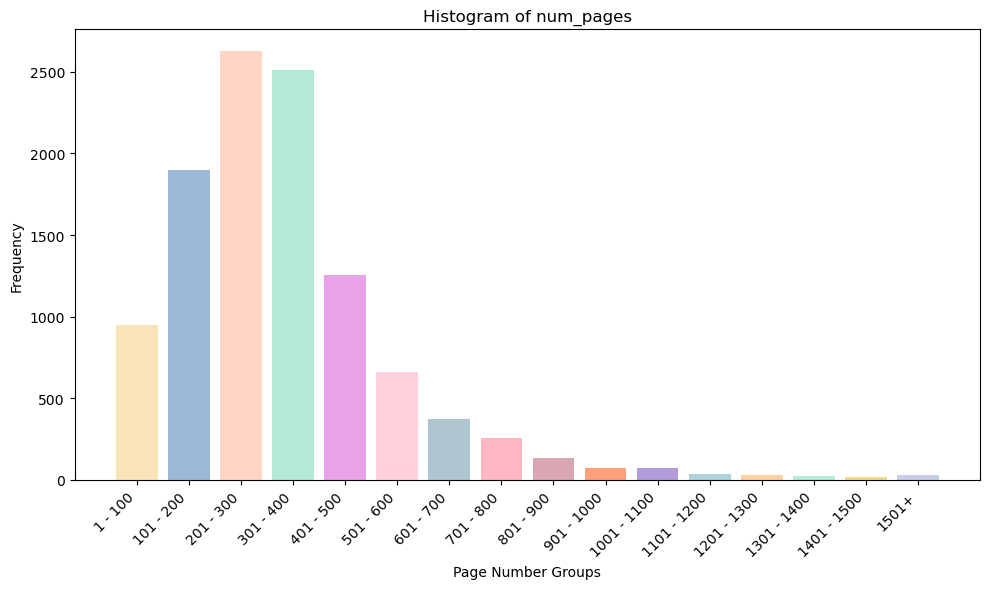

In [6]:
# Fun colors to use in the graph
colors = ['#F9E4B7', '#9AB9D9', '#FFD6C5', '#B5EAD7', '#E8A2E7', '#FFD1DC', '#AEC6CF', '#FFB7C5', '#D8A7B1', '#FFA07A', 
          '#B19CD9', '#ABD3DB', '#FFD1A0', '#B5EAD7', '#F0DC82', '#C7CEEA']

# Get the frequency of each bin
bin_counts = book_df['page_bins'].value_counts().sort_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))  # Adjusted the figure size to fit data
plt.bar(range(len(bin_counts)), bin_counts, color=colors)

# Add axis labels
plt.xlabel('Page Number Groups')
plt.ylabel('Frequency')

# Add title
plt.title('Histogram of num_pages')

# Fix the tick marks for the x-axis
plt.xticks(range(len(bin_counts)), bin_counts.index, rotation=45, ha='right')

# Adjusted layout to prevent overlap of labels
plt.tight_layout()

### average_rating binning

In [7]:
# Convert average_rating to float
book_df['average_rating'] = book_df['average_rating'].astype(float)

In [8]:
# Create bin edges (every 0.5 rating) max out at 5
bin_rating_edges = np.arange(1, 5.5, .5)

# Define bin labels
bin_rating_labels = [f"{i} - {i + .5}" for i in bin_rating_edges[:-1]]

# Create 'rating_bins' column using cut function
book_df['rating_bins'] = pd.cut(book_df['average_rating'], bins=bin_rating_edges, labels=bin_rating_labels, include_lowest=True)

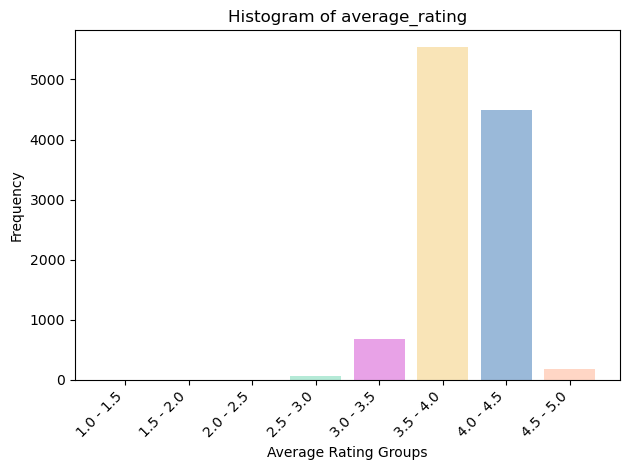

In [9]:
# Fun colors to use in the graph
colors = ['#F9E4B7', '#9AB9D9', '#FFD6C5', '#B5EAD7', '#E8A2E7']

# Get the frequency of each bin
bin_rating_counts = book_df['rating_bins'].value_counts().sort_index()

# Plotting the histogram
plt.bar(range(len(bin_rating_counts)), bin_rating_counts, color=colors)

# Add axis labels
plt.xlabel('Average Rating Groups')
plt.ylabel('Frequency')

# Add title
plt.title('Histogram of average_rating')

# Fix the tick marks for the x-axis
plt.xticks(range(len(bin_rating_counts)), bin_rating_counts.index, rotation=45, ha='right')

# Adjusted layout to prevent overlap of labels
plt.tight_layout()

### ratings_count binning

In [10]:
# Convert ratings_count to int
book_df['ratings_count'] = book_df['ratings_count'].astype(int)

In [11]:
# Create bin edges (every 5000 ratings) and max out at 50000
bin_count_ratings_edges = list(range(1, min(book_df['ratings_count'].max(), 50002), 5000))

# Add a bin edge for ratings_count greater than 50000
bin_count_ratings_edges.append(float('inf'))

# Define bin labels
bin_count_ratings_labels = [f"{i} - {i + 4999}" for i in bin_count_ratings_edges[:-1]]
bin_count_ratings_labels[-1] = f"{bin_count_ratings_edges[-2]}+"

# Create 'count_ratings_bins' column using cut function
book_df['count_ratings_bins'] = pd.cut(book_df['ratings_count'], bins=bin_count_ratings_edges, labels=bin_count_ratings_labels, include_lowest=True)

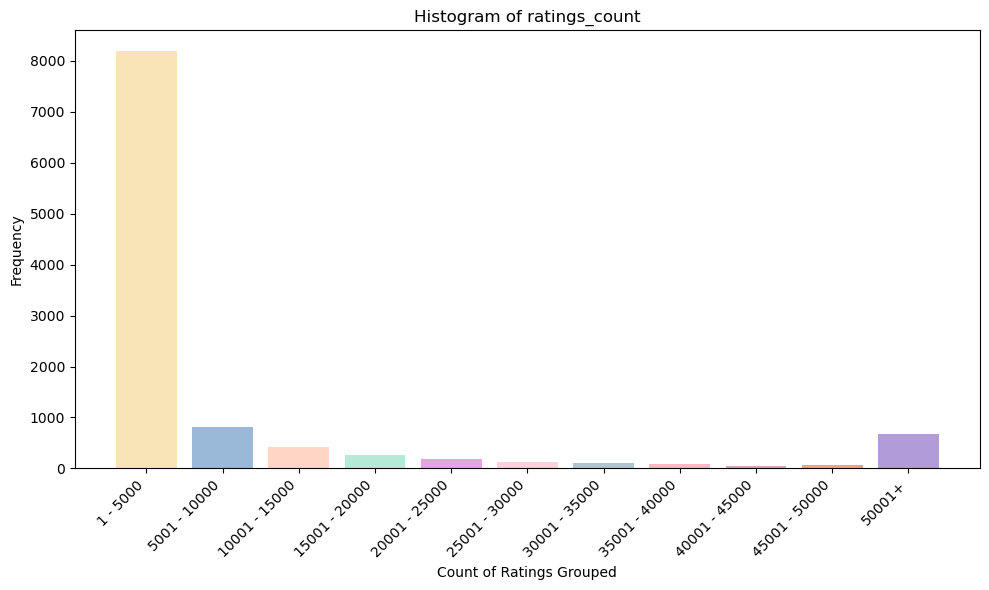

In [12]:
# Fun colors to use in the graph
colors = ['#F9E4B7', '#9AB9D9', '#FFD6C5', '#B5EAD7', '#E8A2E7', '#FFD1DC', '#AEC6CF', '#FFB7C5', '#D8A7B1', '#FFA07A', 
          '#B19CD9', '#ABD3DB', '#FFD1A0', '#B5EAD7', '#F0DC82', '#C7CEEA']

# Get the frequency of each bin
ratings_count_bin_counts = book_df['count_ratings_bins'].value_counts().sort_index()

# Adjust the figure size to fit data
plt.figure(figsize=(10, 6)) 

# Creating a histogram with the bins that were made and set colors to the pretty colors array
plt.bar(range(len(ratings_count_bin_counts)), ratings_count_bin_counts, color=colors)

# Add axis labels
plt.xlabel('Count of Ratings Grouped')
plt.ylabel('Frequency')

# Add title
plt.title('Histogram of ratings_count')

# Fix the tick marks for the x-axis
plt.xticks(range(len(ratings_count_bin_counts)), ratings_count_bin_counts.index, rotation=45, ha='right')

# Adjusted layout to prevent overlap of labels
plt.tight_layout()

### text_reviews_count binning

In [13]:
# Convert text_reviews_count to int
book_df['text_reviews_count'] = book_df['text_reviews_count'].astype(int)

In [14]:
# Create bin edges (every 100 ratings) and max out at 1500
text_reviews_edges = list(range(0, min(book_df['text_reviews_count'].max(), 1501), 100))

# Add a bin edge for ratings_count greater than 1500
text_reviews_edges.append(float('inf'))

# Define bin labels
text_reviews_labels = [f"{i} - {i + 100}" for i in text_reviews_edges[:-1]]
text_reviews_labels[-1] = f"{text_reviews_edges[-2]}+"

# Create 'comments_count_bins' column using cut function
book_df['comments_count_bins'] = pd.cut(book_df['text_reviews_count'], bins=text_reviews_edges, labels=text_reviews_labels, include_lowest=True)

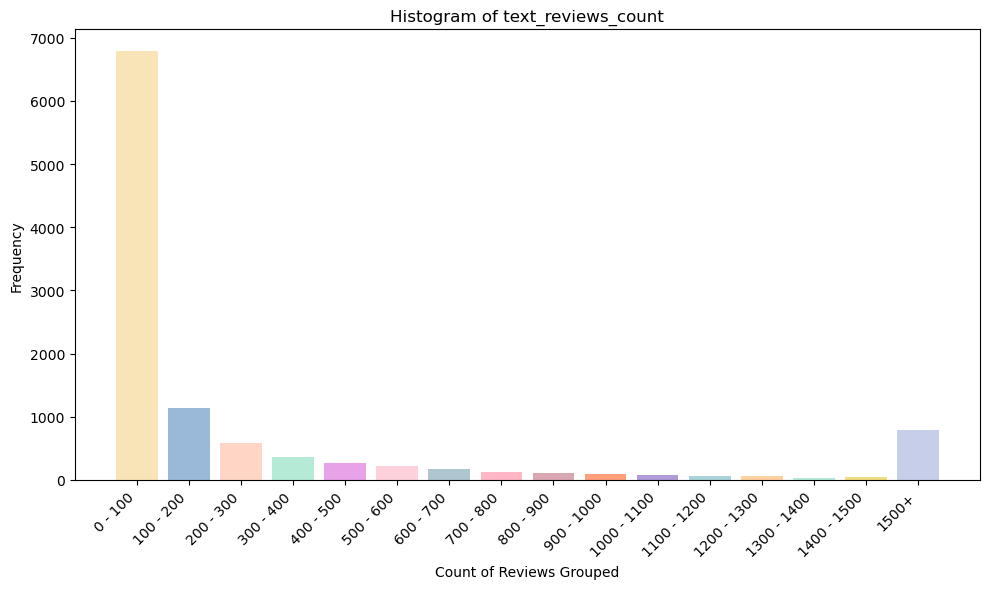

In [15]:
# Fun colors to use in the graph
colors = ['#F9E4B7', '#9AB9D9', '#FFD6C5', '#B5EAD7', '#E8A2E7', '#FFD1DC', '#AEC6CF', '#FFB7C5', '#D8A7B1', '#FFA07A', 
          '#B19CD9', '#ABD3DB', '#FFD1A0', '#B5EAD7', '#F0DC82', '#C7CEEA']

# Get the frequency of each bin
comments_bin_counts = book_df['comments_count_bins'].value_counts().sort_index()

# Adjusted the figure size to fit data
plt.figure(figsize=(10, 6))

# Creating a histogram with the bins that were made and set colors to the pretty colors array
plt.bar(range(len(comments_bin_counts)), comments_bin_counts, color=colors)

# Add axis labels
plt.xlabel('Count of Reviews Grouped')
plt.ylabel('Frequency')

# Add title
plt.title('Histogram of text_reviews_count')

# Fix the tick marks for the x-axis
plt.xticks(range(len(comments_bin_counts)), comments_bin_counts.index, rotation=45, ha='right')

# Adjusted layout to prevent overlap of labels
plt.tight_layout()

### publication_date binning

In [16]:
# Convert 'publication_date' column to datetime
book_df['publication_date'] = pd.to_datetime(book_df['publication_date'])

# Extract date component
book_df['publication_date'] = book_df['publication_date'].dt.date

In [17]:
# Define the start and end dates for the column
start_date = max(pd.to_datetime(book_df['publication_date'].min()), pd.Timestamp(year=1950, month=1, day=1))
end_date = pd.Timestamp.today()

# Create bin edges (every 5 years) and cap at the end date
date_edges = pd.date_range(start=start_date, end=end_date, freq='5Y')

# Define bin labels
date_labels = [f"{date.strftime('%Y')} - {(date + pd.Timedelta(weeks=260)).strftime('%Y')}" for date in date_edges[:-2]]

# If there are dates before 1950, create a label for them
if (pd.to_datetime(book_df['publication_date']).dt.date < date(1950, 1, 1)).any():
    date_labels.insert(0, 'Before 1950')

# Create 'publication_date_counts' column using cut function
book_df['publication_date_counts'] = pd.cut(pd.to_datetime(book_df['publication_date']), bins=date_edges, labels=date_labels, include_lowest=True)

C:\Users\ld718712\AppData\Local\Temp\ipykernel_34476\973196577.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_edges = pd.date_range(start=start_date, end=end_date, freq='5Y')


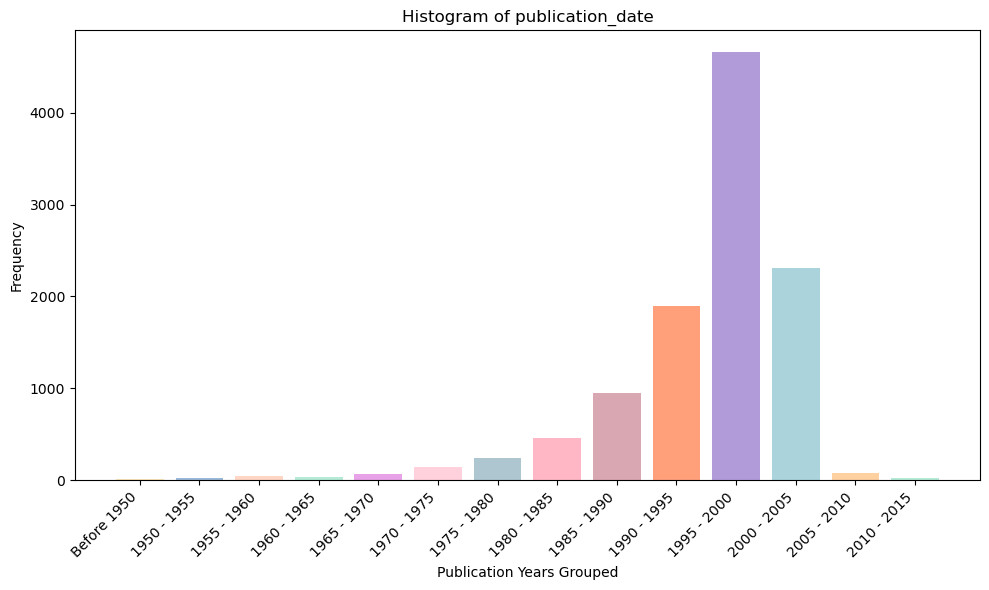

In [18]:
# Fun colors to use in the graph
colors = ['#F9E4B7', '#9AB9D9', '#FFD6C5', '#B5EAD7', '#E8A2E7', '#FFD1DC', '#AEC6CF', '#FFB7C5', '#D8A7B1', '#FFA07A', 
          '#B19CD9', '#ABD3DB', '#FFD1A0', '#B5EAD7', '#F0DC82', '#C7CEEA']

# Get the frequency of each bin
date_bins_count = book_df['publication_date_counts'].value_counts().sort_index()

# Adjusted the figure size to fit data
plt.figure(figsize=(10, 6))

# Creating a histogram with the bins that were made and set colors to the pretty colors array
plt.bar(range(len(date_bins_count)), date_bins_count, color=colors)

# Add axis labels
plt.xlabel('Publication Years Grouped')
plt.ylabel('Frequency')

# Add title
plt.title('Histogram of publication_date')

# Fix the tick marks for the x-axis
plt.xticks(range(len(date_bins_count)), date_bins_count.index, rotation=45, ha='right')

# Adjusted layout to prevent overlap of labels
plt.tight_layout()

## <font color='#FFA07A'>4. Descriptive Characteristics</font>

### num_pages

In [19]:
# Grab the mean of the column
num_pages_mean = book_df['num_pages'].mean()

# Print the mean to only two decimals
print('num_pages MEAN is:', round(num_pages_mean ,2))

num_pages MEAN is: 339.01


In [20]:
# Grab the mode of the column
num_pages_mode = book_df['num_pages'].mode().values[0]

# Print the mode
print('num_pages MODE is:', num_pages_mode)

num_pages MODE is: 288


In [21]:
# Grab the variance of the column
num_pages_variance = book_df['num_pages'].var()

# Print the variance to only two decimals
print('num_pages SPREAD is:', round(num_pages_variance, 2))

num_pages SPREAD is: 57687.13


In [22]:
# Calculate kurtosis of the num_pages column
num_pages_kurtosis = kurtosis(book_df['num_pages'])

# Identify tails based on kurtosis
if num_pages_kurtosis > 0:
    # Select values greater than the mean plus one standard deviation
    tail_values = book_df[book_df['num_pages'] > book_df['num_pages'].mean() + book_df['num_pages'].std()]['num_pages']
else:
    # Select values less than the mean minus one standard deviation
    tail_values = book_df[book_df['num_pages'] < book_df['num_pages'].mean() - book_df['num_pages'].std()]['num_pages']

# Print the tails
print("num_pages TAILS are:", tail_values.values)

num_pages TAILS are: [ 652  870 2690 ...  592  816  635]


### average_rating

In [23]:
# Grab the mean of the column
average_rating_mean = book_df['average_rating'].mean()

# Print the mean to only two decimals
print('average_rating MEAN is:', round(average_rating_mean, 2))

average_rating MEAN is: 3.94


In [24]:
# Grab the mode of the column
average_rating_mode = book_df['average_rating'].mode().values[0]

# Print the mode
print('average_rating MODE is:', average_rating_mode)

average_rating MODE is: 4.0


In [25]:
# Grab the variance of the column
average_rating_variance = book_df['average_rating'].var()

# Print the variance to only two decimals
print('average_rating SPREAD is:', round(average_rating_variance, 2))

average_rating SPREAD is: 0.09


In [26]:
# Calculate kurtosis of the num_pages column
average_rating_kurtosis = kurtosis(book_df['average_rating'])

# Identify tails based on kurtosis
if average_rating_kurtosis > 0:
    # Select values greater than the mean plus one standard deviation
    tail_values = book_df[book_df['average_rating'] > book_df['average_rating'].mean() + book_df['average_rating'].std()]['average_rating']
else:
    # Select values less than the mean minus one standard deviation
    tail_values = book_df[book_df['average_rating'] < book_df['average_rating'].mean() - book_df['average_rating'].std()]['average_rating']

# Print the tails
print("average_rating TAILS are:", tail_values.values)

average_rating TAILS are: [4.57 4.49 4.42 ... 4.26 4.26 4.26]


### ratings_count

In [27]:
# Grab the mean of the column
ratings_count_mean = book_df['ratings_count'].mean()

# Print the mean to only two decimals
print('ratings_count MEAN is:', round(ratings_count_mean, 2))

ratings_count MEAN is: 18196.14


In [28]:
# Grab the mode of the column
ratings_count_mode = book_df['ratings_count'].mode().values[0]

# Print the mode
print('ratings_count MODE is:', ratings_count_mode)

ratings_count MODE is: 3


In [29]:
# Grab the variance of the column
ratings_count_variance = book_df['ratings_count'].var()

# Print the variance to only two decimals
print('ratings_count SPREAD is:', round(ratings_count_variance, 2))

ratings_count SPREAD is: 12832694612.3


In [30]:
# Calculate kurtosis of the num_pages column
ratings_count_kurtosis = kurtosis(book_df['ratings_count'])

# Identify tails based on kurtosis
if ratings_count_kurtosis > 0:
    # Select values greater than the mean plus one standard deviation
    tail_values = book_df[book_df['ratings_count'] > book_df['ratings_count'].mean() + book_df['ratings_count'].std()]['ratings_count']
else:
    # Select values less than the mean minus one standard deviation
    tail_values = book_df[book_df['ratings_count'] < book_df['ratings_count'].mean() - book_df['ratings_count'].std()]['ratings_count']

# Print the tails
print("ratings_count TAILS are:", tail_values.values)

ratings_count TAILS are: [2095690 2153167 2339585  249558  248558 2128944  270244  153317  318753
  251872  166046  211671  322483  188100 1631221 1755253  142121  280309
 1301083 2418736 1679706  166916  200744  190039  297533  628745  206011
  132062  184418  288792  760871  609271  132064  141555 1054308  138101
  800349  274649  168362  351406 1479727  271754  441462  540349  133840
  282649  140014  184293  633037  168559  167321  140403  209122 1049912
  764134  238192  520051  154933  555995  201488 1585589  189652  208684
  133237  160911  239652  165862  282127  383045  335477  311436  321078
  225397  191531  157572 1001671  470858  173022 2457092  167157 1247221
  744569  175779  227716  294348  760717  160706  151818  540910  367399
  222140  131876  146659  502726  147748  388782  234954  218195 2530894
  282045  606433  161582  558799  380646  193117  328542  159883  283199
  549271  208669  647271  483122  613758  166136  808656  131662 2111750
 2036679  202043  144636  

### text_reviews_count

In [31]:
# Grab the mean of the column
text_reviews_count_mean = book_df['text_reviews_count'].mean()

# Print the mean to only two decimals
print('text_reviews_count MEAN is:', round(text_reviews_count_mean, 2))

text_reviews_count MEAN is: 549.68


In [32]:
# Grab the mode of the column
text_reviews_count_mode = book_df['text_reviews_count'].mode().values[0]

# Print the mode
print('text_reviews_count MODE is:', text_reviews_count_mode)

text_reviews_count MODE is: 0


In [33]:
# Grab the variance of the column
text_reviews_count_variance = book_df['text_reviews_count'].var()

# Print the variance to only two decimals
print('text_reviews_count SPREAD is:', round(text_reviews_count_variance, 2))

text_reviews_count SPREAD is: 6729874.33


In [34]:
# Calculate kurtosis of the num_pages column
text_reviews_count_kurtosis = kurtosis(book_df['text_reviews_count'])

# Identify tails based on kurtosis
if text_reviews_count_kurtosis > 0:
    # Select values greater than the mean plus one standard deviation
    tail_values = book_df[book_df['text_reviews_count'] > book_df['text_reviews_count'].mean() + book_df['text_reviews_count'].std()]['text_reviews_count']
else:
    # Select values less than the mean minus one standard deviation
    tail_values = book_df[book_df['text_reviews_count'] < book_df['text_reviews_count'].mean() - book_df['text_reviews_count'].std()]['text_reviews_count']

# Print the tails
print("text_reviews_count TAILS are:", tail_values.values)

text_reviews_count TAILS are: [27591 29221 36325  4080  9396  4245  3301 13670 12017  4551  5696  6734
  6241  3324  6446  6245 14702  7277  4249  6612 55843 25554  8782  3703
 19296 21303 35877  3400  6243  7656  4922 14935 13034 10821  3303  4432
  4155  3167  4702  3423  6557  7139  5452 35537  3838 18198  4280  7203
  5762 11701 18458  4076 10063  3535 11308 19548  6118  5325  7778  5418
 11898  4711  3332  4131 11391 11796  4392  3422  8192 16562  3229  5295
 10173  3496  4212 56604  3657  8207  3358  5677  7468  4087  9777  5860
  3317  9143 13449  3881 15962 19241  4808  3909  8421  8423 12452  6795
  6203  8463  8549 19056 15859  3332  6152  5139 43499  4994 20014  7247
  6261  3407  3860  9096  7546 17179  3738  6198  4136  3399  3378  3375
 11121  8009  9645  3685  3490  9654  4058 13012  5168 32871  9004  3916
 34301  9026  7239 22957  4733  7012  4997 11117  5816  9489 14249 10265
  3718 19846  4750 46176  4267  3536  6561 29677 26199  3647  3485  7255
  3532  8711  3556  6

### publication_date

In [35]:
# Convert publication_date to datetime format
book_df['publication_date'] = pd.to_datetime(book_df['publication_date'])

# Calculate the mean date
publication_date_mean = book_df['publication_date'].mean()

# Print the mean date
print('publication_date MEAN is:', publication_date_mean.strftime('%Y-%m-%d'))

publication_date MEAN is: 2000-09-03


In [36]:
# Calculate the mode date
publication_date_mode = book_df['publication_date'].mode().values[0]

# Print the mode date
print('publication_date MODE is:', publication_date_mode)

publication_date MODE is: 2005-10-01T00:00:00.000000000


In [37]:
# Calculate the standard deviation of the publication dates
publication_date_std = book_df['publication_date'].std()

# Print the spread/std of the publication dates
print('publication_date SPREAD is:', publication_date_std.days)

publication_date SPREAD is: 2999


In [38]:
# Extract the number of days from the Timedelta object
publication_date_std_days = publication_date_std.days

# Identify tails based on standard deviation
if publication_date_std_days > 0:
    # Select values greater than the mean plus one standard deviation
    tail_values = book_df[book_df['publication_date'] > publication_date_mean + publication_date_std]['publication_date']
else:
    # Select values less than the mean minus one standard deviation
    tail_values = book_df[book_df['publication_date'] < publication_date_mean - publication_date_std]['publication_date']

# Print the tails
print("publication_date TAILS are:", tail_values.dt.strftime('%Y-%m-%d').values)

publication_date TAILS are: ['2012-09-25' '2011-06-14' '2011-01-12' '2009-07-07' '2009-03-04'
 '2012-04-03' '2019-02-11' '2015-03-24' '2009-07-15' '2009-10-06'
 '2010-01-01' '2019-04-02' '2010-03-31' '2010-04-21' '2013-12-13'
 '2017-08-17' '2012-09-06' '2010-10-05' '2009-09-01' '2010-08-25'
 '2012-01-01' '2010-03-16' '2010-10-06' '2009-04-23' '2013-06-19'
 '2009-01-01' '2010-08-31' '2011-05-31' '2016-10-11' '2013-11-26'
 '2012-07-24' '2012-03-27' '2017-09-21' '2011-03-15' '2017-03-10'
 '2013-07-01' '2011-11-24' '2010-02-01' '2009-08-19' '2009-06-09'
 '2009-09-29' '2012-06-21' '2009-10-27' '2009-05-19' '2010-06-09'
 '2014-08-20' '2009-06-01' '2013-03-01' '2016-06-30' '2015-04-21'
 '2009-07-22' '2010-12-31' '2018-03-06' '2011-10-21' '2011-03-03'
 '2009-01-01' '2015-08-03' '2011-05-22' '2009-04-14' '2013-10-15'
 '2008-12-16' '2010-03-30' '2019-08-06' '2012-01-03' '2012-12-26'
 '2018-02-19' '2015-02-25' '2018-12-12' '2014-12-10' '2009-08-05'
 '2017-04-07' '2009-07-01' '2010-11-12' '2010-12

## <font color='#FFA07A'>5. Compare Two Scenarios Using a PMF</font>

In [39]:
# Grab the rows where the book is less than 350 pages
small_book = book_df[(book_df['num_pages'] < 350)]

# Grab the rows where the book is greater than 350
big_book = book_df[(book_df['num_pages'] >= 350)]

In [40]:
# Calculate the PMF for small books
pmf_small_book = thinkstats2.Pmf(small_book['average_rating'])

# Calculate the PMF for big books
pmf_big_book = thinkstats2.Pmf(big_book['average_rating'])

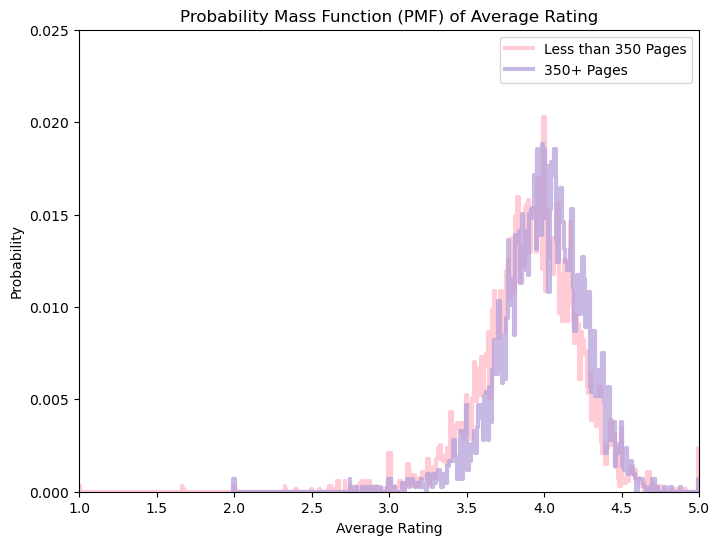

<Figure size 800x600 with 0 Axes>

In [41]:
# Create the plot with correct sizing
thinkplot.PrePlot(2, rows=1, cols=1)

# Add in correct variables, labels, and colors
thinkplot.Pmf(pmf_small_book, label='Less than 350 Pages', color='#FFB7C5')
thinkplot.Pmf(pmf_big_book, label='350+ Pages',color= '#B19CD9')

# Add title, x-axis and y-axis labels and control the constraints of the graph
thinkplot.Config(title='Probability Mass Function (PMF) of Average Rating')
thinkplot.Show(xlabel = 'Average Rating', ylabel = 'Probability', axis = [1, 5, 0, 0.025])

## <font color='#FFA07A'>6. Create CDF with average_rating Variable</font>

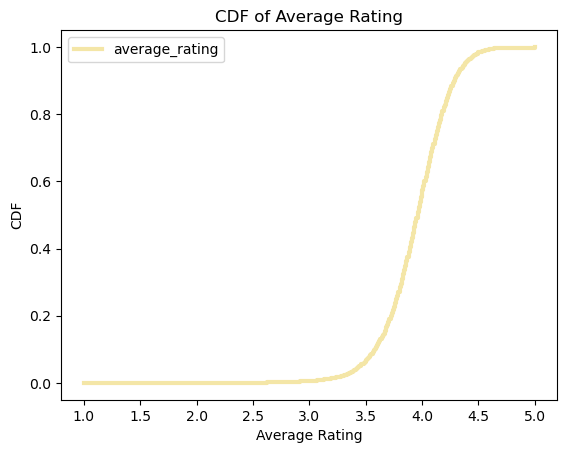

<Figure size 800x600 with 0 Axes>

In [42]:
# Create cdf of average_rating using thinkstats2 library
average_rating_cdf = thinkstats2.Cdf(book_df['average_rating'])

# Plot the CDF and give it a label and color
thinkplot.Cdf(average_rating_cdf, color='#F0DC82', label='average_rating')

# Add axis labels and title
thinkplot.Config(xlabel='Average Rating', ylabel='CDF', title='CDF of Average Rating')
thinkplot.Show()

#### What does the CDF tell me about average_rating and how does it address the question I'm trying to answer?

This tells me that essentially 90% of average book ratings fall between 3.5 to 4.5. It also tells me that rating a book a 4 is a pretty common rating, since it is a more vertical line there. This addresses the question I'm trying to answer by showing me that most books, regardless of page number, will have an average rating of around 3.5 to 4.5 (not a large window).

## <font color='#FFA07A'>7. Plot One Analytical Distribution: Normal Probability Plot</font>

In [43]:
# Create normal probability plots for small books using variable created prior
normal_prob_plot_small_book = thinkstats2.NormalProbability(small_book['average_rating'])

# Create normal probability plots for big books using variable created prior
normal_prob_plot_big_book = thinkstats2.NormalProbability(big_book['average_rating'])

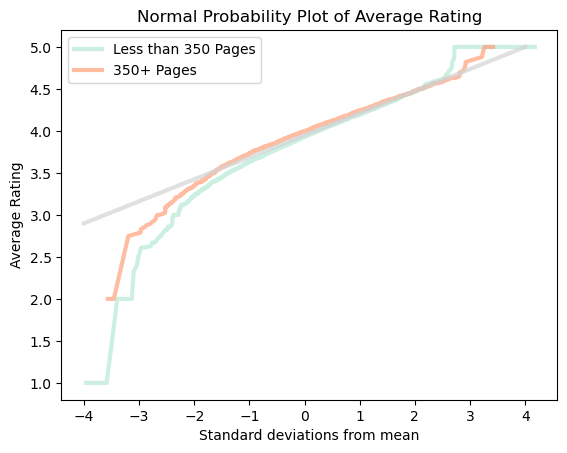

In [44]:
# Plot the normal probability plot for small books
thinkplot.Plot(normal_prob_plot_small_book[0], normal_prob_plot_small_book[1], label='Less than 350 Pages', color='#B5EAD7')

# Plot the normal probability plot for big books
thinkplot.Plot(normal_prob_plot_big_book[0], normal_prob_plot_big_book[1], label='350+ Pages', color = '#FFA07A')

# Add the gray line representing the ideal normal distribution
thinkplot.Plot([-4, 4], [2.9, 5], color='#D3D3D3')

# Add axis labels and title
thinkplot.Config(title='Normal Probability Plot of Average Rating',
                 xlabel='Standard deviations from mean',
                 ylabel='Average Rating')

#### How does this apply to the dataset I have chosen?

This tells me that there aren't as many scores for both books greater than 350 pages and less than 350 pages, that fall below 3. The line seems to be more stable from 3 to 5, meaning most ratings fall within that range. It also tells me that books with more than 350 pages are rated SLIGHTLY higher for most of the ratings. It looks like the higher the score gets, however, the more the two book sizes start to intersect (at the 4.5 rating mark).

## <font color='#FFA07A'>8. Create Two Scatterplots Comparing Variables</font>

### Comparing num_pages & average_rating

Text(0.5, 1.0, 'Scatter Plot of Number of Pages vs. Average Rating for All Books')

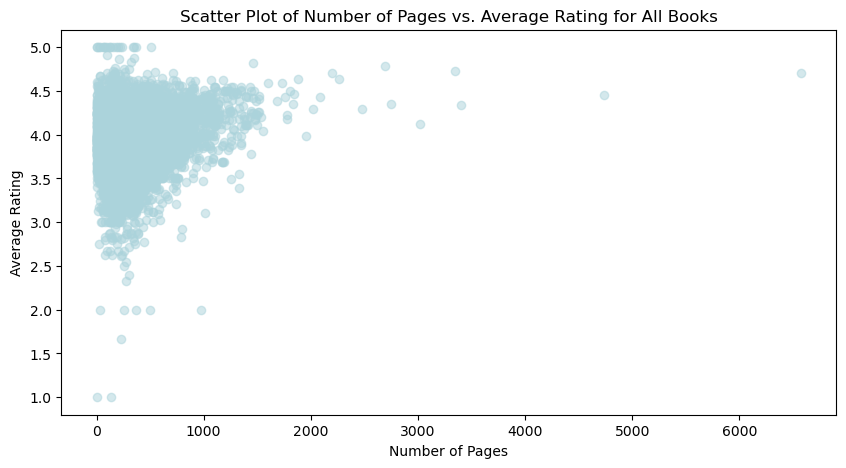

In [45]:
# Create the figure with correct sizing
plt.figure(figsize=(10, 5))

# Create the scatterplot using num_pages as the independent variable and average_rating as dependent variable
plt.scatter(book_df['num_pages'], book_df['average_rating'], alpha=0.5, color='#ABD3DB')

# Add label to x-axis and y-axis
plt.xlabel('Number of Pages')
plt.ylabel('Average Rating')

# Add a title to the scatterplot
plt.title('Scatter Plot of Number of Pages vs. Average Rating for All Books')

#### Analysis on Correlation & Causation

The number of pages does not seem to correlate with average rating, as there is not distinct straight line forming in the data. Also, number of pages does not cause any certain average rating to emerge, and vice versa.

### Grabbing covariance and pearson's correlation values

In [46]:
# Compute covariance
# Took the method from thinkstats2
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

# Compute & Print Covariance
print("Covariance:", Cov(book_df['average_rating'], book_df['num_pages']))

Covariance: 12.075804431943556


In [47]:
# Compute pearson's correlation
# Took the method from thinkstats2
def Corr(xs,ys):
    xs= np.asarray(xs)
    ys= np.asarray(ys)
    
    meanx,varx=thinkstats2.MeanVar(xs)
    meany,vary=thinkstats2.MeanVar(ys)
    
    corr= Cov(xs,ys, meanx,meany) /math.sqrt(varx *vary)
    return corr

# Compute & Print Pearson’s correlation
print("Pearson's Correlation:", Corr(book_df['average_rating'], book_df['num_pages']))

Pearson's Correlation: 0.17071314451100988


#### Covariance and Pearson's Correlation Explanation

The Covariance value of 12.03 indicates a positive linear relationship, while the Pearson's Correlation value of 0.17 indicates a weak positive linear relationship between number of pages and average rating.

### Comparing average_rating & publication_date

Text(0.5, 1.0, 'Scatter Plot of Publicatio Date vs. Average Rating for All Books')

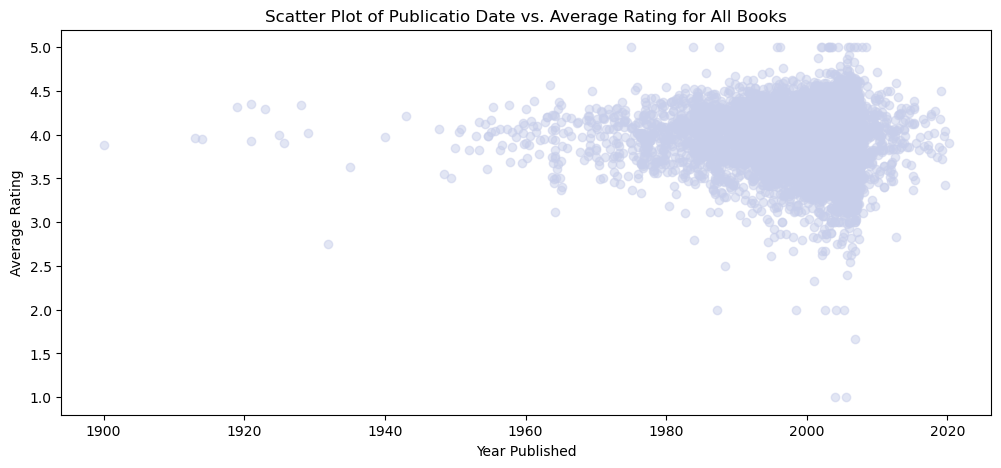

In [48]:
# Create the figure with correct sizing
plt.figure(figsize=(12, 5))

# Create the scatterplot using publication_date as the independent variable and average_rating as dependent variable
plt.scatter(book_df['publication_date'], book_df['average_rating'], alpha=0.5, color='#C7CEEA')

# Add label to x-axis and y-axis
plt.xlabel('Year Published')
plt.ylabel('Average Rating')

# Add a title to the scatterplot
plt.title('Scatter Plot of Publicatio Date vs. Average Rating for All Books')

#### Analysis on Correlation & Causation

The year the book was published does not seem to correlate with average rating, as there is not distinct straight line forming in the data. However, this graph does have a more linear feel than the previous one. Also, publication date does not cause any certain average rating to emerge, and vice versa.

### Grabbing covariance and pearson's correlation values

In [49]:
# Compute & Print Covariance using thinkstats2 method
print("Covariance:", Cov(book_df['average_rating'], book_df['publication_date'].astype(np.int64)))

Covariance: -3423612090940546.5


In [50]:
# Compute & Print Pearson’s correlation using thinkstats2 method
print("Pearson's Correlation:", Corr(book_df['average_rating'], book_df['publication_date'].astype(np.int64)))

Pearson's Correlation: -0.04485445410311277


#### Covariance and Pearson's Correlation Explanation

The Covariance value of -3423612090940548 suggests that there strongly no linear relationship between the two variables, and the Pearson's Correlation value of -0.04 suggests that there is little to no linear relationship between the average rating of books and their publication dates.

## <font color='#FFA07A'>9. Conduct a Test on Hypothesis: HypothesisTest</font>

In [51]:
# Compute difference in means hypothesis testing
# Took the method from thinkstats2
class DiffMeansPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat= abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n,self.m = len(group1), len(group2)
        self.pool= np.hstack((group1,group2))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data =self.pool[:self.n], self.pool[self.n:]
        return data

In [52]:
# Grab the average_rating values from small books and big books
data = small_book.average_rating.values, big_book.average_rating.values

# Create variable that holds the values after being passed through DiffMeansPermute method
ht = DiffMeansPermute(data)

In [53]:
# Calculate the p-value
pvalue = ht.PValue()

# Print the p-value
print('P-Value is:', pvalue)

P-Value is: 0.0


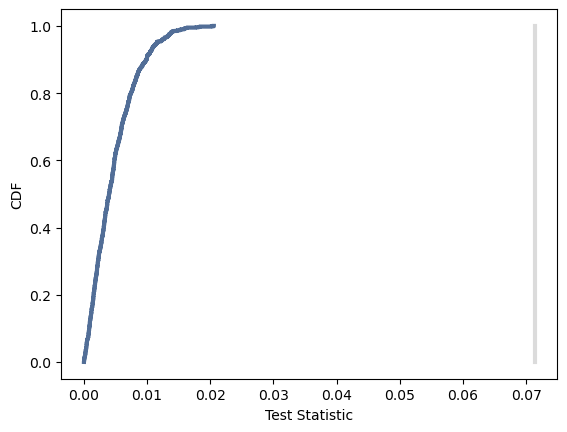

<Figure size 800x600 with 0 Axes>

In [54]:
# Plot the hypothesis test graph
ht.PlotCdf()

# Add labels to the x and y axis
thinkplot.Show(xlabel = 'Test Statistic',
              ylabel = 'CDF')

## <font color='#FFA07A'>10. Regression Analysis on num_pages & average_rating</font>

In [55]:
# Create the OLS Regression model using the average rating as the dependent variable
# and the num_pages as the independent variable.
model = smf.ols('average_rating ~ num_pages', data = book_df)

# Fit the model
results = model.fit()

# Print the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     329.1
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           1.71e-72
Time:                        23:10:24   Log-Likelihood:                -1993.4
No. Observations:               10966   AIC:                             3991.
Df Residuals:                   10964   BIC:                             4005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8723      0.005    807.683      0.0

## <font color='#FFA07A'>11. 250-500 Word Paper Summarizing Results and Analyses</font>

From my EDA, it seems to be that the number of pages in a book does influence how the book will be rated. The p-value of the difference in means between books with less than 350 pages and books with 350 pages or more was 0, showing great statistical significance. The OLS Regression analysis also showed a p-value of 0 between the two variables. However, I think that more analysis needs to be done, like breaking up the data into different chunks, to truly be able to say if page number influences book rating. 

I also think it would be important to take out outliers in the page number and average rating column, because they can greatly skew the data. Some of the outliers I found for page number were 6576 and 4736. These numbers were much higher than the other page numbers in the dataset, the closest being a book that was 3400 pages. I would also take out the three ratings: 1, 1, and 1.67. They skewed the data lower and weren’t necessary in my analysis.

The only variable that I think could have been a helpful addition in my analysis was the variable ratings_count, because it could have given me insight as to why a book was rated a certain way. If only one person rated the book, that’s why the average was so high or so low.

There were some assumptions made that I felt were incorrect. The assumption of book length having an impact on its rating, from the p-values saying that the relationship between book length and ratings was statistically significant, is not quite accurate without more testing, more models, and more manipulation of the actual dataset. In shorter terms, more analysis needs to be done on this topic to know the exact effects of book length on ratings.

One of the challenges I faced was having to bin a Date datatype, as well as having to get the descriptive characteristics for that datatype. I also found binning in general to be more difficult, mainly because I didn’t know what the best bins would be (what the cutoffs for each one should be). It was also difficult to graph some of the visuals and make the formatting of the graph look exactly how I wanted it to best represent the data.

A part of the analysis that I don’t fully understand would have to be the HypothesisTest results, but I am trying to do more digging on this – even after class is over – because I want to have a better understanding of what the graph is telling me. 

To conclude, it was found that there is a statistically significant difference in rating for larger books and smaller books based on the previous analyses. Though this statistical question needs more research to confirm these findings, it is a great start for more research like this. I had a fun time diving into this project and am grateful for all that this class has taught me! Thank you for a wonderful semester!